In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow.keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam # - Works
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score

In [2]:
Sales_df = pd.read_csv('model_df.csv')
print(Sales_df.shape)
Sales_df.info()

(47, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        47 non-null     object 
 1   sales       47 non-null     int64  
 2   sales_diff  47 non-null     float64
 3   lag_1       47 non-null     float64
 4   lag_2       47 non-null     float64
 5   lag_3       47 non-null     float64
 6   lag_4       47 non-null     float64
 7   lag_5       47 non-null     float64
 8   lag_6       47 non-null     float64
 9   lag_7       47 non-null     float64
 10  lag_8       47 non-null     float64
 11  lag_9       47 non-null     float64
 12  lag_10      47 non-null     float64
 13  lag_11      47 non-null     float64
 14  lag_12      47 non-null     float64
dtypes: float64(13), int64(1), object(1)
memory usage: 5.6+ KB


In [3]:
#Train_Test split using function
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values #first 35 rows for training, from 12 rows  for testing
    
    return train, test

train, test = tts(Sales_df) #function call 

In [4]:
#Data scaling using function
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1]) #TO ensure that scaled data is in same shape as Train set
    train_set_scaled = scaler.transform(train_set)
    # reshape test set


    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)


    X_train, Y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, Y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel() #ravel converts 2D array to 1D array
    
    return X_train, Y_train, X_test, Y_test, scaler

X_train, Y_train, X_test, Y_test, scaler_object = scale_data(train, test)
print(f"""shape of x_train {X_train.shape}
shape of x_test {X_test.shape}
shape of y_train {Y_train.shape}
shape of y_test {Y_test.shape}""")

shape of x_train (35, 12)
shape of x_test (12, 12)
shape of y_train (35,)
shape of y_test (12,)


In [5]:
#unscaled = undo_scaling(predictions, X_test, scaler_object)
def undo_scaling(Y_pred, X_test, scaler_obj):  
    #reshape y_pred
    Y_pred = Y_pred.reshape(Y_pred.shape[0], 1, 1)
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(Y_pred)):
        pred_test_set.append(np.concatenate([Y_pred[index],X_test[index]],axis=1))
    print(pred_test_set)    
    #reshape pred_test_set
    #as we know we converted the data from 2d-3d time to convert back from 3d-2d
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [6]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('train.csv')
    print("orginal_df",original_df)
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3]) # removing day
    print("type",type(original_df.date[0]))
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    original_df
    return original_df
load_original_df()

orginal_df               date  store  item  sales
0       2013-01-01      1     1     13
1       2013-01-02      1     1     11
2       2013-01-03      1     1     14
3       2013-01-04      1     1     13
4       2013-01-05      1     1     10
...            ...    ...   ...    ...
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82

[913000 rows x 4 columns]
type <class 'str'>


,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


In [7]:
#unscaled_df = predict_df(unscaled, original_df)
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date) #last 12 rows date
    act_sales = list(original_df[-13:].sales) #last 12 rows sales 
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [8]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    #original last 12 rows and pred last 12 rows 
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    print(f"R2 Score: {r2}")

In [9]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig(f'{model_name}_forecast.png')

In [10]:
def LSTM_model(train_data, test_data):
    
    X_train, Y_train, X_test, Y_test, scaler_object = scale_data(train_data, test_data)
    #data is scaled 
    #x_train shape is 35,12  2d
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #x_train shape will be 35,1,12
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=10, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
    print("unscaled_df",unscaled_df)
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')

Epoch 1/10
35/35 [==============================] - 1s 2ms/step - loss: 0.3904
Epoch 2/10
35/35 [==============================] - 0s 2ms/step - loss: 0.3532
Epoch 3/10
35/35 [==============================] - 0s 2ms/step - loss: 0.3037
Epoch 4/10
35/35 [==============================] - 0s 2ms/step - loss: 0.2696
Epoch 5/10
35/35 [==============================] - 0s 1ms/step - loss: 0.2432
Epoch 6/10
35/35 [==============================] - 0s 1ms/step - loss: 0.2216
Epoch 7/10
35/35 [==============================] - 0s 2ms/step - loss: 0.2033
Epoch 8/10
35/35 [==============================] - 0s 2ms/step - loss: 0.1875
Epoch 9/10
35/35 [==============================] - 0s 2ms/step - loss: 0.1735
Epoch 10/10
12/12 [==============================] - 0s 1ms/step
orginal_df               date  store  item  sales
0       2013-01-01      1     1     13
1       2013-01-02      1     1     11
2       2013-01-03      1     1     14
3       2013-01-04      1     1     13
4       2013-01-05

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


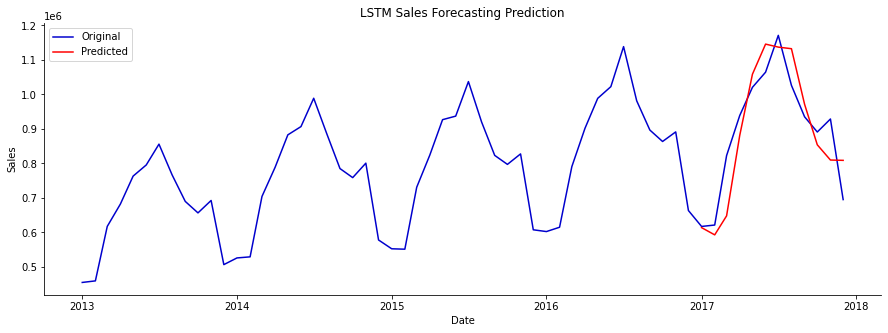

In [11]:
#model calling
LSTM_model(train, test)